In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum 

In [2]:
N = 10000
n_day=1000
n_jobs=100
n_new = 30
n_expert = 7
n_experienced = 63
coeffs = [0.5, 0.5, 0.5]
alpha=0.1

In [3]:
def sample(x, scores=None, n=1):
    if scores is None:
        scores = np.ones_like(x, dtype=np.float)
    probs = np.exp(scores - np.max(scores)) / np.sum(np.exp(scores - np.max(scores)))
    return np.random.choice(x, size=n, p=probs).tolist()

In [4]:
# Setting default feature vectors for categories classes of workers
WorkerType = Enum('WorkerType', 'new experienced expert')
class GigWorker:
    def __init__(self, category=WorkerType.new, idx=0):
        self.category = category
        self.idx = idx
        if category == WorkerType.new:
            self.true_skill = np.random.uniform()
            self.effort = 0.25 + 0.5 * np.random.uniform()
            self.algo_score = 0.5
        elif category == WorkerType.expert:
            self.true_skill = 0.9 + 0.1 * np.random.uniform()
            self.effort = 0.9 + 0.1 * np.random.uniform()
            self.algo_score = 0.9 + 0.1 * np.random.uniform()
        elif category == WorkerType.experienced:
            self.true_skill = 0.9 * np.random.uniform()
            self.effort = 0.9 * np.random.uniform()
            self.algo_score = 0.9 * np.random.uniform()
    def act(self):
        pass

In [5]:
lb = 0
new_workers = [GigWorker(WorkerType.new, i) for i in range(int(N * 0.16))]
lb += int(N * 0.16)
experienced_workers = [GigWorker(WorkerType.experienced, i) for i in range(lb, lb+int(N * 0.84 * 0.9))]
lb += int(N * 0.84 * 0.9)
expert_workers = [GigWorker(WorkerType.expert, i) for i in range(lb, lb+int(N * 0.84 * 0.1))]

In [6]:
def get_days_workers(new_workers, experienced_workers, expert_workers, n_day=n_day):
    prop = n_day / N
    s1 = sample(new_workers, n=int(prop * len(new_workers)))
    s2 = sample(experienced_workers, n=int(prop * len(experienced_workers)))
    s3 = sample(expert_workers, n=int(prop * len(expert_workers)))
    return s1, s2, s3

In [7]:
def select_worker(workers, coeffs):
    features = np.array([[worker.true_skill * worker.algo_score,
                         worker.true_skill,
                         worker.algo_score] for worker in workers])
    scores = features @ np.array(coeffs)
    idx = sample(list(range(len(workers))), scores=scores.reshape(-1), n=1)[0]
    return workers[idx], workers[:idx] + workers[(idx + 1):]

In [8]:
def simulate_day(new_workers, experienced_workers, expert_workers, n_jobs=n_jobs):
    s1, s2, s3 = get_days_workers(new_workers, experienced_workers, expert_workers)
    drop_offs = []
    for job in range(n_jobs):
        s1_efforts = [worker.effort for worker in s1]
        s2_efforts = [worker.effort for worker in s2]
        s3_efforts = [worker.effort for worker in s3]
        job_workers = sample(s1, s1_efforts, n=n_new) + sample(s2, s2_efforts, n=n_experienced) + sample(s3, s3_efforts, n=n_expert)
        chosen, other = select_worker(job_workers, coeffs)
        # Handle chosen
        job_score = sample([1, 2, 3, 4, 5], scores=np.log([0.05, 0.05, 0.05, 0.05, 0.8]))[0]
        chosen.algo_score = (1 - alpha) * chosen.algo_score + (alpha) * (job_score / 5)
        chosen.effort *= 1.05
        if chosen.category == WorkerType.new:
            s1.remove(chosen)
        elif chosen.category == WorkerType.experienced:
            s2.remove(chosen)
        elif chosen.category == WorkerType.expert:
            s3.remove(chosen)
        # Handle others
        for worker in other:
            if worker.category == WorkerType.new:
                if np.random.rand() > 0.85:
                    drop_offs.append(worker)
                else:
                    worker.effort *= 1.1
            else: # experienced worker
                if np.random.rand() > 0.01: #do nothing
                    pass
                else:
                    worker.effort *= 1.1
    for worker in set(drop_offs):
        new_workers.remove(worker)
        new_workers.append(GigWorker(WorkerType.new, idx=int(np.random.uniform() * 1000000)))

In [9]:
avg_new_effort = []
for day in range(14):
    # print("day", day + 1)
    simulate_day(new_workers, experienced_workers, expert_workers)
    avg_new_effort.append(np.mean([worker.effort for worker in new_workers]))

Text(0, 0.5, 'avg effort score of new person')

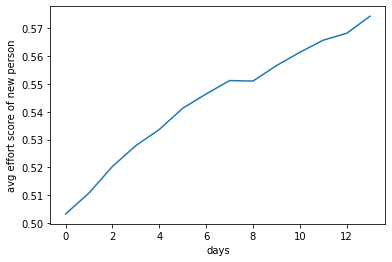

In [10]:
plt.plot(avg_new_effort)
plt.xlabel("days")
plt.ylabel("avg effort score of new person")